# 4 Nodes

## Data Loading

In [3]:
import pandas as pd

# Read data from CSV file
df = pd.read_csv('4-nodes.csv')

# Convert string representations to dictionaries
df['cpu_usage_percentage'] = df['cpu_usage_percentage'].apply(eval)
df['mem_usage_percentage'] = df['mem_usage_percentage'].apply(eval)

# Function to calculate average CPU utilization
def calculate_avg(row):
    values = list(row.values())
    if len(values) != 4: return -1
    return sum(values) / len(values)

# Apply the function to each row
df['avg_cpu_utilization'] = df['cpu_usage_percentage'].apply(calculate_avg)
df['avg_mem_utilization'] = df['mem_usage_percentage'].apply(calculate_avg)

# Drop rows where Prometheus querying is wrong
df = df[df['avg_cpu_utilization'] != -1]
df = df[df['avg_mem_utilization'] != -1]

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             712 non-null    object 
 1   cluster_node_list     712 non-null    object 
 2   cpu_usage_percentage  712 non-null    object 
 3   node_status           712 non-null    object 
 4   cpu_reserve           712 non-null    object 
 5   mem_usage_percentage  712 non-null    object 
 6   mem_reserve           712 non-null    object 
 7   Power                 712 non-null    int64  
 8   Energy                712 non-null    float64
 9   avg_cpu_utilization   712 non-null    float64
 10  avg_mem_utilization   712 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 61.3+ KB


## Visualization Average CPU / Memory vs POWER

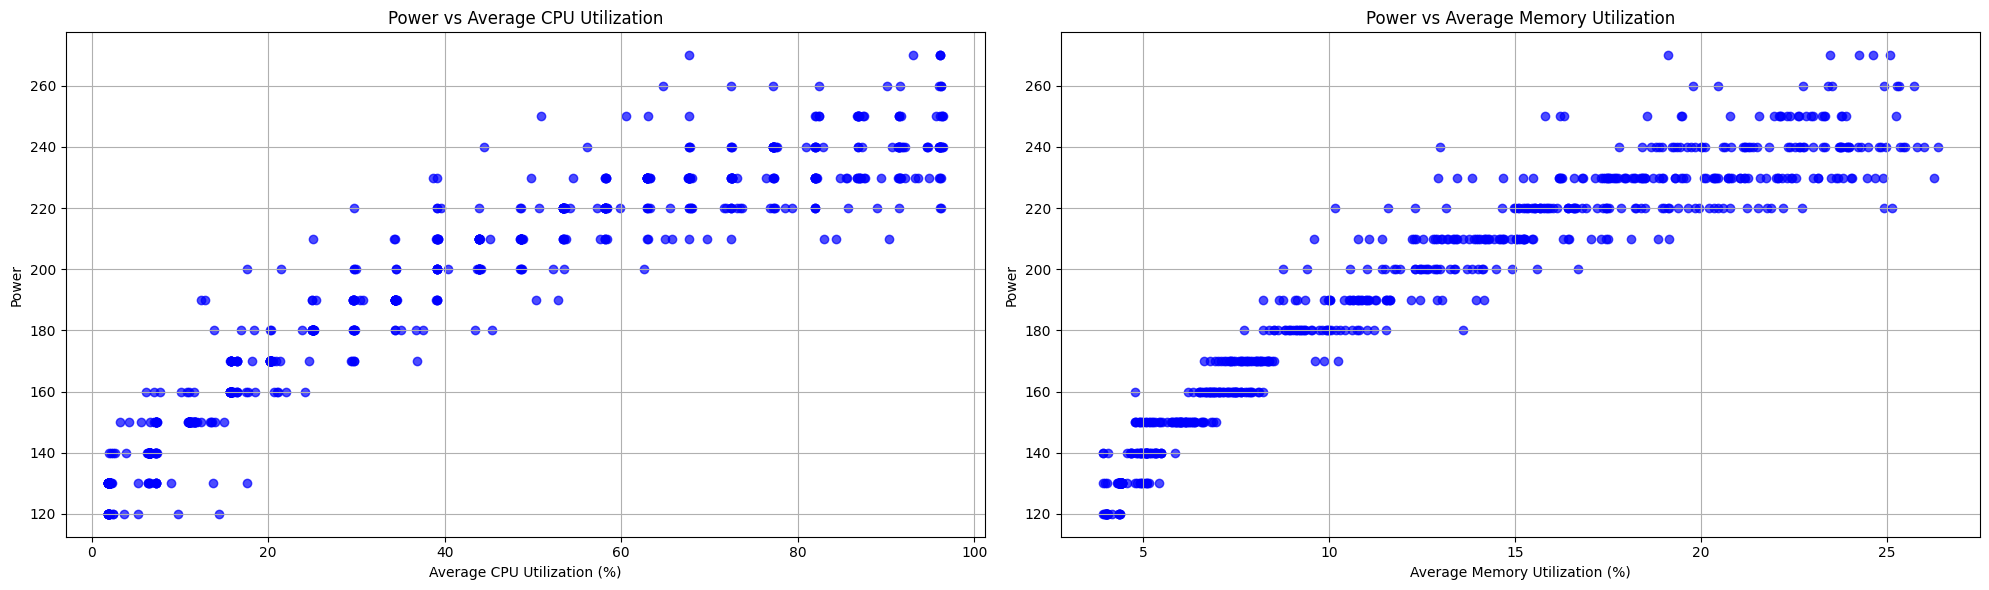

In [4]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Power vs Average CPU Utilization
axes[0].scatter(df['avg_cpu_utilization'], df['Power'], color='blue', alpha=0.7)
axes[0].set_title('Power vs Average CPU Utilization')
axes[0].set_xlabel('Average CPU Utilization (%)')
axes[0].set_ylabel('Power')
axes[0].grid(True)

# Plot 2: Power vs Average Memory Utilization
axes[1].scatter(df['avg_mem_utilization'], df['Power'], color='blue', alpha=0.7)
axes[1].set_title('Power vs Average Memory Utilization')
axes[1].set_xlabel('Average Memory Utilization (%)')
axes[1].set_ylabel('Power')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Curve Fitting

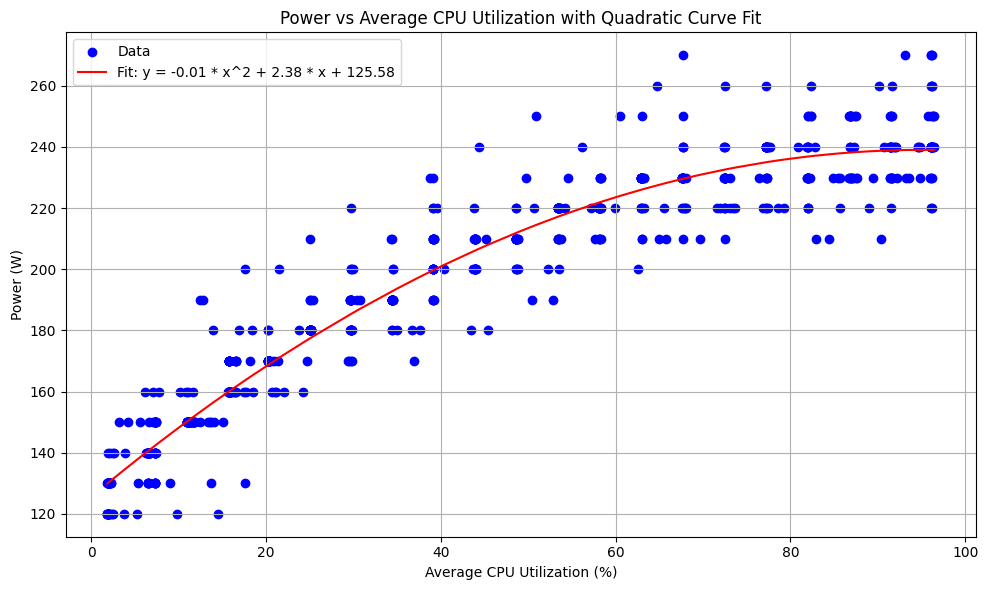

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Define the quadratic model function: y = a * x^2 + b * x + c
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Extract x and y data
x_data = df['avg_cpu_utilization']
y_data = df['Power']

# Perform curve fitting
popt, pcov = curve_fit(quadratic_model, x_data, y_data)

# Obtain the fitted parameters
a_fit, b_fit, c_fit = popt

# Predicted y values based on the fitted model
y_fit = quadratic_model(x_data, a_fit, b_fit, c_fit)

# Sorting x_data and corresponding y_data
sorted_indices = np.argsort(x_data)
x_sorted = x_data.iloc[sorted_indices]
y_sorted = y_data.iloc[sorted_indices]
y_fit_sorted = y_fit[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', label='Data')
plt.plot(x_sorted, y_fit_sorted, color='red', label=f'Fit: y = {a_fit:.2f} * x^2 + {b_fit:.2f} * x + {c_fit:.2f}')
plt.title('Power vs Average CPU Utilization with Quadratic Curve Fit')
plt.xlabel('Average CPU Utilization (%)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Linear Regression

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)
regression_df.head()

,cpu_usage_cillium4,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,mem_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,Power
0,0.37,5.69,0.73,0.83,3.14,6.43,2.91,3.21,130
1,0.43,7.63,0.77,0.79,3.14,6.54,2.91,3.21,120
2,0.44,7.77,0.69,0.92,3.14,6.51,2.91,3.20,140
3,0.49,7.47,0.82,0.93,3.14,6.42,2.91,3.20,120
4,0.44,6.01,1.05,1.16,3.14,6.38,2.97,3.23,140


In [7]:
X_LR = regression_df.drop('Power', axis=1)  # Features
y_LR = regression_df['Power']               # Target variable

X_train, X_test, y_train, y_test = train_test_split(X_LR, y_LR, test_size=0.2, random_state=0)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = model.predict(X_test)

# Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# R^2 Score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 192.9703905476445
R^2 Score: 0.872156225375693
Coefficients: [ 0.063446   -0.61707303  0.06834755  0.84139767  0.98576942  0.64160177
  0.4687983   1.81616009]
Intercept: 127.29409806000086


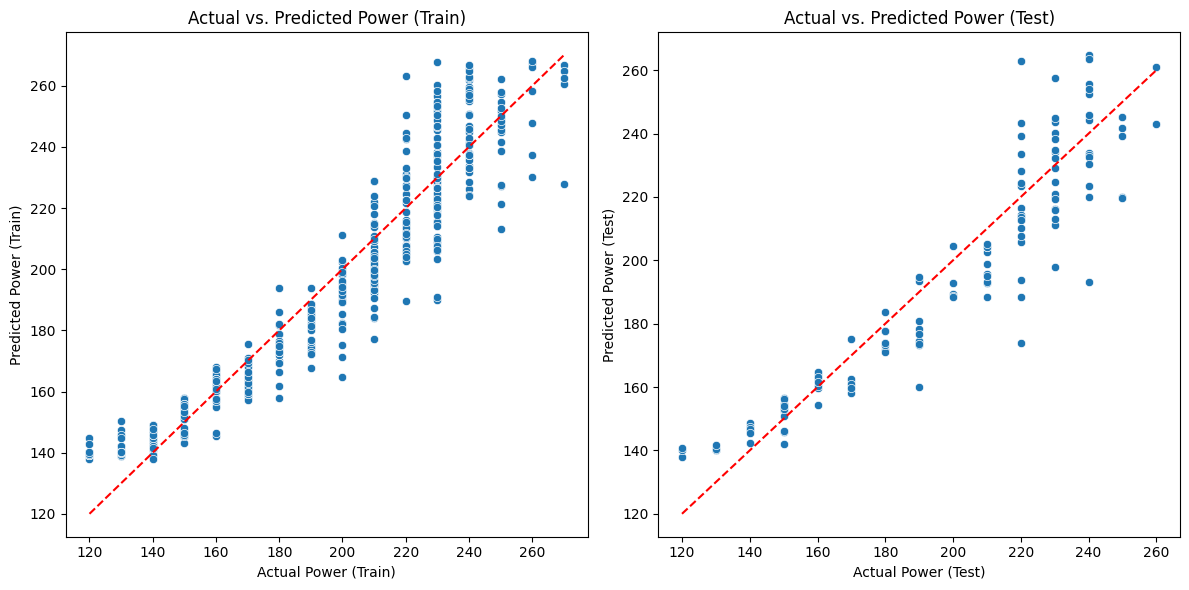

In [9]:
import seaborn as sns
# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()

## Neural Network

In [10]:
# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)
regression_df.head()

,cpu_usage_cillium4,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,mem_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,Power
0,0.37,5.69,0.73,0.83,3.14,6.43,2.91,3.21,130
1,0.43,7.63,0.77,0.79,3.14,6.54,2.91,3.21,120
2,0.44,7.77,0.69,0.92,3.14,6.51,2.91,3.20,140
3,0.49,7.47,0.82,0.93,3.14,6.42,2.91,3.20,120
4,0.44,6.01,1.05,1.16,3.14,6.38,2.97,3.23,140


In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
X = regression_df.drop('Power', axis=1)  # Features
y = regression_df['Power']               # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with a single node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=2, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Patchapong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 36531.4258 - val_loss: 16147.9395
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12662.6787 - val_loss: 5696.4209
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6795.1318 - val_loss: 4658.5864
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4206.4731 - val_loss: 3191.3323
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3227.8406 - val_loss: 1584.7648
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1471.4994 - val_loss: 798.0135
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 811.4485 - val_loss: 487.1301
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 541.8797 - val_loss: 257.9570
Epoch 9/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 316.7608 - val_loss: 152.1975
Epoch 10/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 193.3285 - val_loss: 109.3368
Epoch 11/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137.0387 - val_loss: 81.0

In [14]:
# Make predictions
y_train_pred = model.predict(X_train).flatten()  # Flatten to make it 1D
y_test_pred = model.predict(X_test).flatten()    # Flatten to make it 1D

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test R^2 Score: {r2_test}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
Training Mean Squared Error: 83.50018433523162
Test Mean Squared Error: 70.28522836987965
Training R^2 Score: 0.9470592737197876
Test R^2 Score: 0.9607067108154297


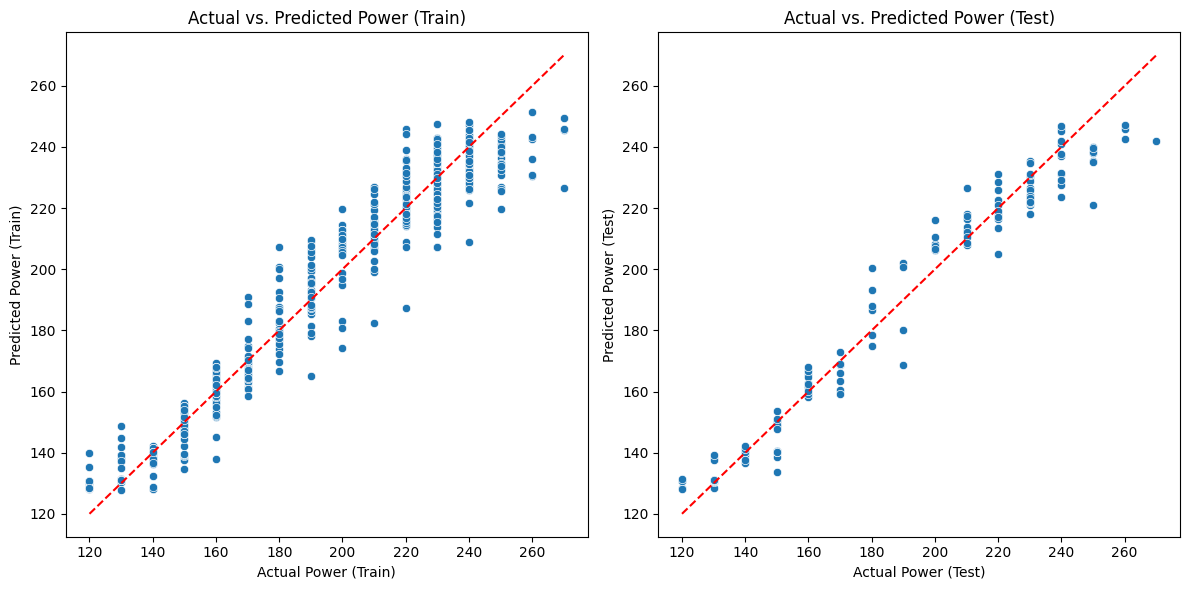

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()


In [16]:
import joblib

# Save the model
model.save('power_model_4node.keras')

# Save the scaler
joblib.dump(scaler, 'scaler_4node.pkl')

['scaler_4node.pkl']

# 3 Nodes

## Data Loading

In [18]:
import pandas as pd

# Read data from CSV file
df1 = pd.read_csv('3-nodes-1.csv')
df2 = pd.read_csv('3-nodes-2.csv')
df3 = pd.read_csv('3-nodes-3.csv')
df  = pd.concat([df1, df2, df3])

# Convert string representations to dictionaries
df['cpu_usage_percentage'] = df['cpu_usage_percentage'].apply(eval)
df['mem_usage_percentage'] = df['mem_usage_percentage'].apply(eval)

# Function to calculate average CPU utilization
def calculate_avg(row):
    values = list(row.values())
    if len(values) != 3: return -1
    return sum(values) / len(values)

# Apply the function to each row
df['avg_cpu_utilization'] = df['cpu_usage_percentage'].apply(calculate_avg)
df['avg_mem_utilization'] = df['mem_usage_percentage'].apply(calculate_avg)

# Drop rows where Prometheus querying is wrong
df = df[df['avg_cpu_utilization'] != -1]
df = df[df['avg_mem_utilization'] != -1]

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 795 entries, 0 to 794
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             795 non-null    object 
 1   cluster_node_list     795 non-null    object 
 2   cpu_usage_percentage  795 non-null    object 
 3   node_status           795 non-null    object 
 4   cpu_reserve           795 non-null    object 
 5   mem_usage_percentage  795 non-null    object 
 6   mem_reserve           795 non-null    object 
 7   Power                 795 non-null    int64  
 8   Energy                795 non-null    float64
 9   avg_cpu_utilization   795 non-null    float64
 10  avg_mem_utilization   795 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 68.4+ KB


## Data Visualization

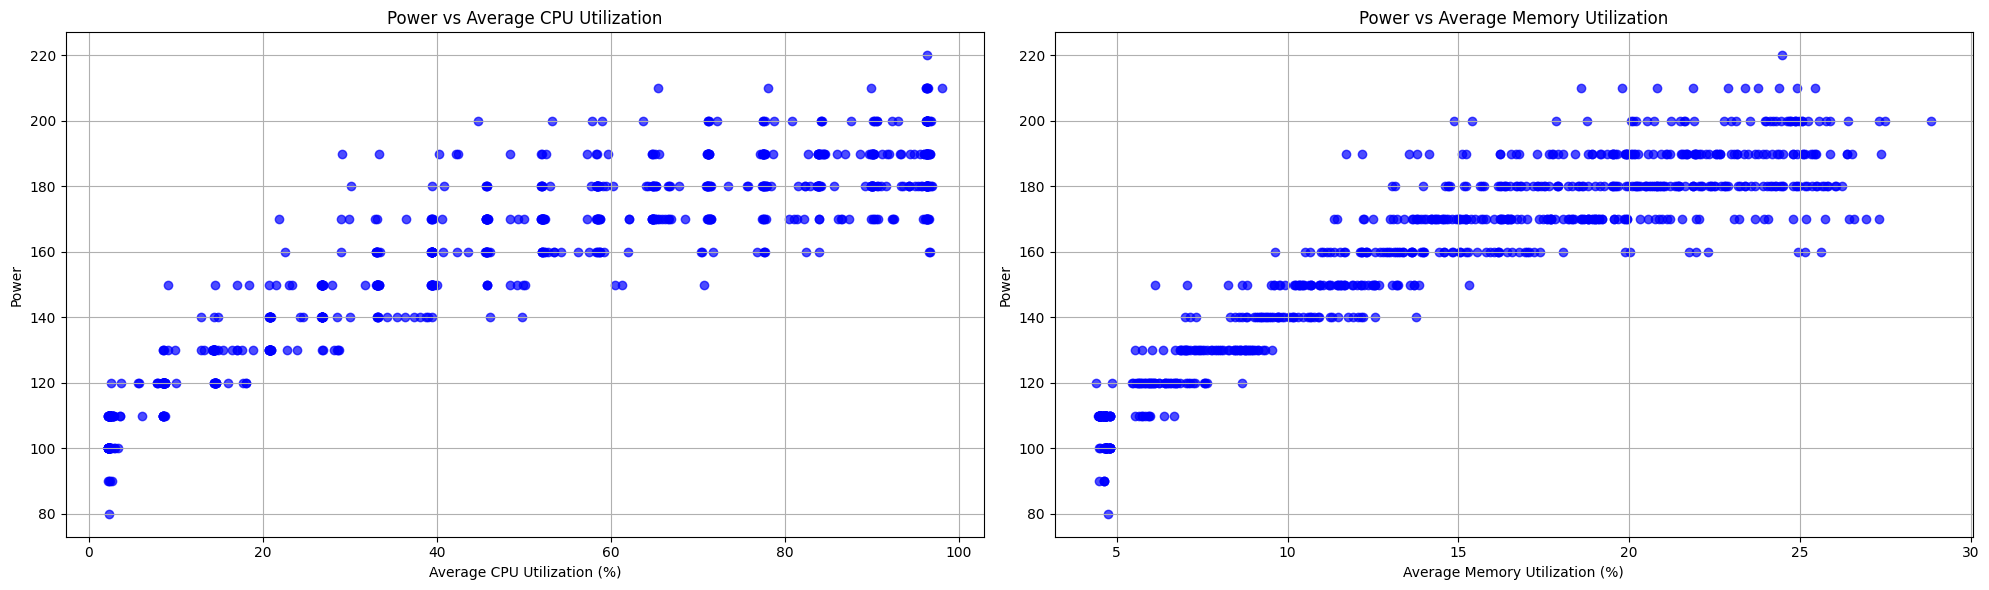

In [19]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Power vs Average CPU Utilization
axes[0].scatter(df['avg_cpu_utilization'], df['Power'], color='blue', alpha=0.7)
axes[0].set_title('Power vs Average CPU Utilization')
axes[0].set_xlabel('Average CPU Utilization (%)')
axes[0].set_ylabel('Power')
axes[0].grid(True)

# Plot 2: Power vs Average Memory Utilization
axes[1].scatter(df['avg_mem_utilization'], df['Power'], color='blue', alpha=0.7)
axes[1].set_title('Power vs Average Memory Utilization')
axes[1].set_xlabel('Average Memory Utilization (%)')
axes[1].set_ylabel('Power')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Curve Fitting

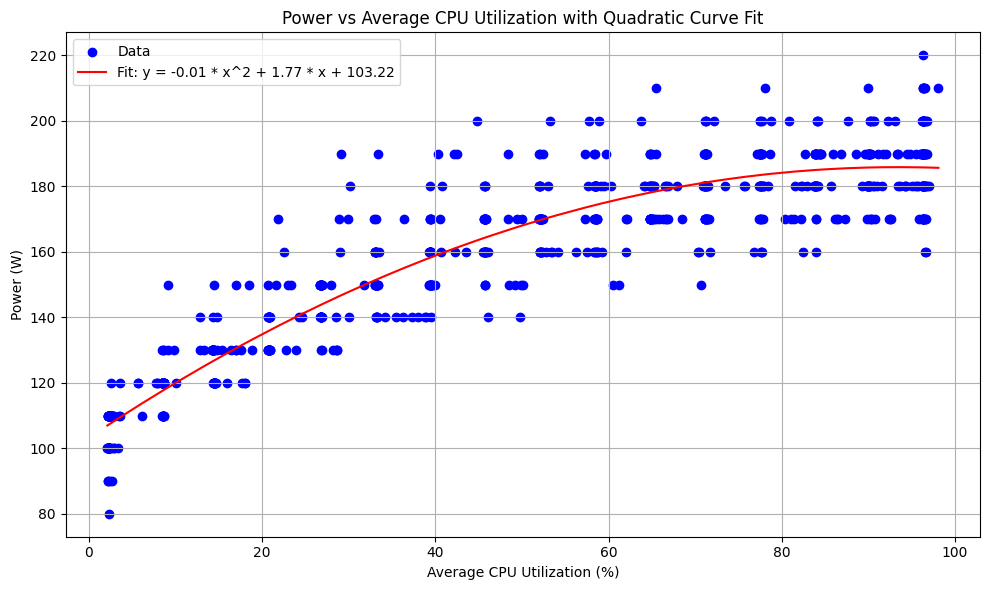

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Define the quadratic model function: y = a * x^2 + b * x + c
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Extract x and y data
x_data = df['avg_cpu_utilization']
y_data = df['Power']

# Perform curve fitting
popt, pcov = curve_fit(quadratic_model, x_data, y_data)

# Obtain the fitted parameters
a_fit, b_fit, c_fit = popt

# Predicted y values based on the fitted model
y_fit = quadratic_model(x_data, a_fit, b_fit, c_fit)

# Sorting x_data and corresponding y_data
sorted_indices = np.argsort(x_data)
x_sorted = x_data.iloc[sorted_indices]
y_sorted = y_data.iloc[sorted_indices]
y_fit_sorted = y_fit[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', label='Data')
plt.plot(x_sorted, y_fit_sorted, color='red', label=f'Fit: y = {a_fit:.2f} * x^2 + {b_fit:.2f} * x + {c_fit:.2f}')
plt.title('Power vs Average CPU Utilization with Quadratic Curve Fit')
plt.xlabel('Average CPU Utilization (%)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural Network

In [21]:
# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)

# Replace NaN values with 0
regression_df.fillna(0, inplace=True)

regression_df.head()

,cpu_usage_cillium4,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,mem_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,Power
0,0.40,5.62,0.69,0.0,3.28,7.91,2.99,0.0,100
1,0.36,5.58,0.59,0.0,3.28,7.94,2.99,0.0,100
2,0.38,5.44,0.72,0.0,3.28,7.83,2.99,0.0,100
3,0.41,5.71,0.79,0.0,3.26,7.88,2.99,0.0,100
4,0.43,5.74,0.68,0.0,3.25,7.86,2.99,0.0,100


In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
X = regression_df.drop('Power', axis=1)  # Features
y = regression_df['Power']               # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with a single node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=3, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Patchapong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 23735.7266 - val_loss: 12359.8330
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6664.2788 - val_loss: 1705.7227
Epoch 3/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1701.9840 - val_loss: 1038.8728
Epoch 4/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 950.4473 - val_loss: 652.5714
Epoch 5/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 572.6580 - val_loss: 444.8463
Epoch 6/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 422.8983 - val_loss: 352.9348
Epoch 7/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 358.8666 - val_loss: 292.1074
Epoch 8/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 283.5685 - val_loss: 282.0928
Epoch 9/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 251.4004 - val_loss: 242.7529
Epoch 10/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 231.5423 - val_loss: 219.4328
Epoch 11/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 208.2605 - val_loss: 204.5706
E

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator, RegressorMixin

class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, optimizer='adam', neurons1=64, neurons2=32, batch_size=10, epochs=100, verbose=0):
        self.optimizer = optimizer
        self.neurons1 = neurons1
        self.neurons2 = neurons2
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_model(self):
        model = Sequential([
            Dense(self.neurons1, activation='relu', input_shape=(X_train.shape[1],)),
            Dense(self.neurons2, activation='relu'),
            Dense(1)
        ])
        optimizer = Adam() if self.optimizer == 'adam' else RMSprop()
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

    def score(self, X, y):
        return -self.model.evaluate(X, y, verbose=0)
    
# Function to create model, required for KerasRegressor
def create_model(optimizer='adam', neurons1=64, neurons2=32):
    model = Sequential([
        Dense(neurons1, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(neurons2, activation='relu'),
        Dense(1)  # Output layer with a single node
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Create the KerasRegressor
model = KerasRegressor()

# Define the grid of hyperparameters to search
param_grid = {
    'batch_size': [3, 5],
    'epochs': [50],
    'optimizer': ['adam', 'rmsprop'],
    'neurons1': [32, 64, 128],
    'neurons2': [16, 32, 64]
}

# Create EarlyStopping callback
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)

# Fit the GridSearchCV object
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and best score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Use the best model to evaluate on the test set
best_model = grid_result.best_estimator_
test_loss = best_model.score(X_test, y_test)
print("Test loss: ", test_loss)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [23]:
# Make predictions
y_train_pred = model.predict(X_train).flatten()  # Flatten to make it 1D
y_test_pred = model.predict(X_test).flatten()    # Flatten to make it 1D

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test R^2 Score: {r2_test}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Mean Squared Error: 93.09482988576993
Test Mean Squared Error: 65.5483523418189
Training R^2 Score: 0.8974586725234985
Test R^2 Score: 0.9226212501525879


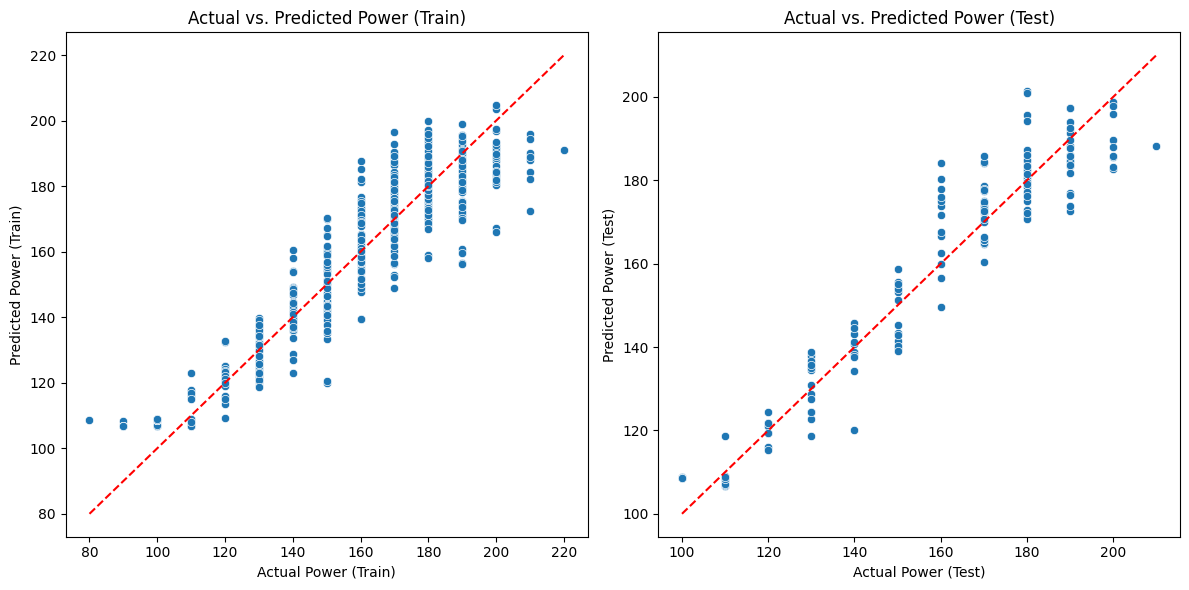

In [217]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()

# 2 Nodes

## Data Loading

In [220]:
import pandas as pd

# Read data from CSV file
df1 = pd.read_csv('2-nodes-1.csv')
df2 = pd.read_csv('2-nodes-2.csv')
df3 = pd.read_csv('2-nodes-3.csv')
df  = pd.concat([df1, df2, df3])

# Convert string representations to dictionaries
df['cpu_usage_percentage'] = df['cpu_usage_percentage'].apply(eval)
df['mem_usage_percentage'] = df['mem_usage_percentage'].apply(eval)

# Function to calculate average CPU utilization
def calculate_avg(row):
    values = list(row.values())
    if len(values) != 2: return -1
    return sum(values) / len(values)

# Apply the function to each row
df['avg_cpu_utilization'] = df['cpu_usage_percentage'].apply(calculate_avg)
df['avg_mem_utilization'] = df['mem_usage_percentage'].apply(calculate_avg)

# Drop rows where Prometheus querying is wrong
df = df[df['avg_cpu_utilization'] != -1]
df = df[df['avg_mem_utilization'] != -1]

# Reset index
df.reset_index(drop=True, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554 entries, 0 to 553
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   timestamp             554 non-null    object 
 1   cluster_node_list     554 non-null    object 
 2   cpu_usage_percentage  554 non-null    object 
 3   node_status           554 non-null    object 
 4   cpu_reserve           554 non-null    object 
 5   mem_usage_percentage  554 non-null    object 
 6   mem_reserve           554 non-null    object 
 7   Power                 554 non-null    int64  
 8   Energy                554 non-null    float64
 9   avg_cpu_utilization   554 non-null    float64
 10  avg_mem_utilization   554 non-null    float64
dtypes: float64(3), int64(1), object(7)
memory usage: 47.7+ KB


## Data Visualization

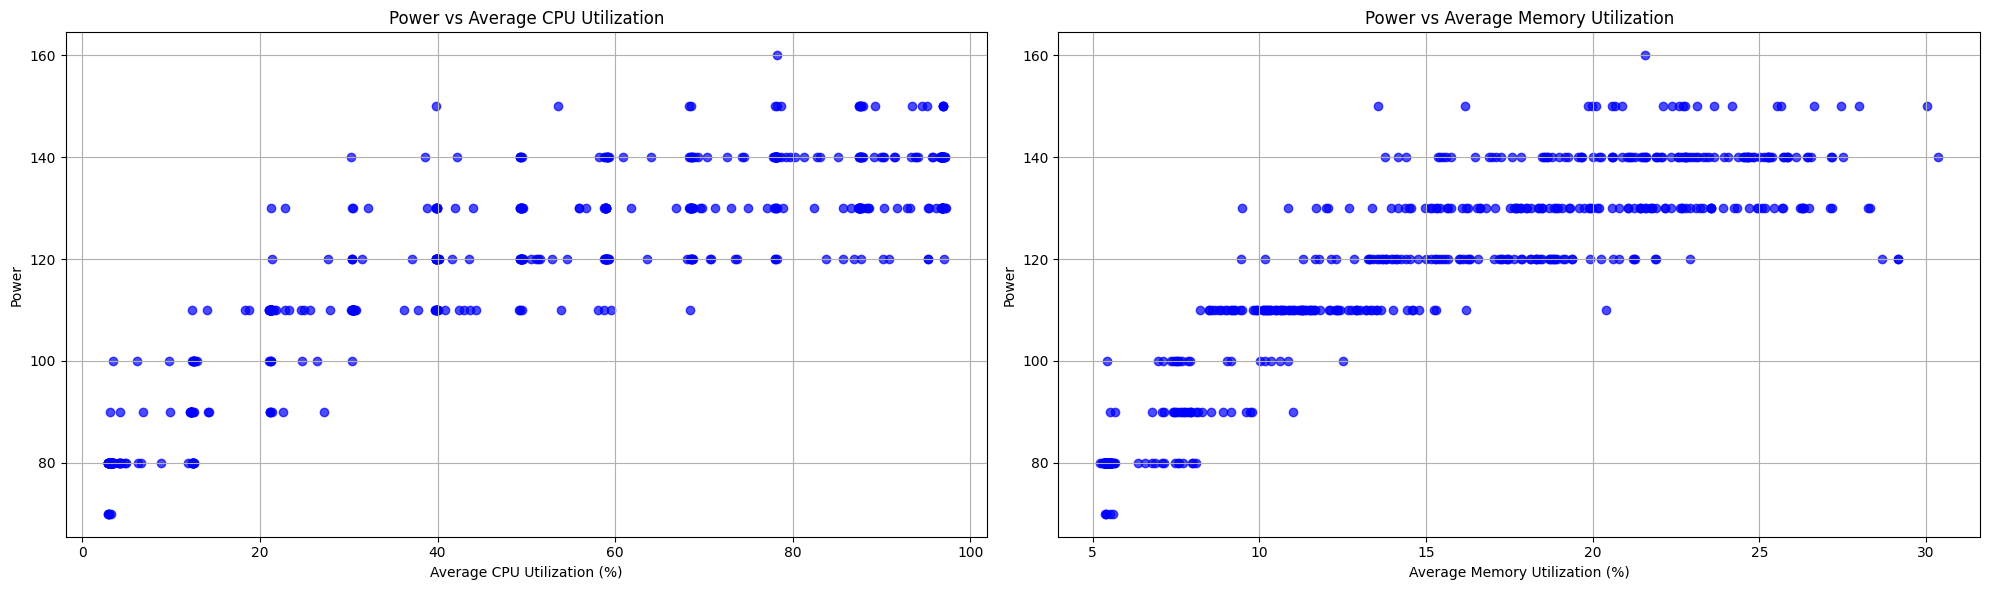

In [221]:
import matplotlib.pyplot as plt
# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))

# Plot 1: Power vs Average CPU Utilization
axes[0].scatter(df['avg_cpu_utilization'], df['Power'], color='blue', alpha=0.7)
axes[0].set_title('Power vs Average CPU Utilization')
axes[0].set_xlabel('Average CPU Utilization (%)')
axes[0].set_ylabel('Power')
axes[0].grid(True)

# Plot 2: Power vs Average Memory Utilization
axes[1].scatter(df['avg_mem_utilization'], df['Power'], color='blue', alpha=0.7)
axes[1].set_title('Power vs Average Memory Utilization')
axes[1].set_xlabel('Average Memory Utilization (%)')
axes[1].set_ylabel('Power')
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Curve Fitting

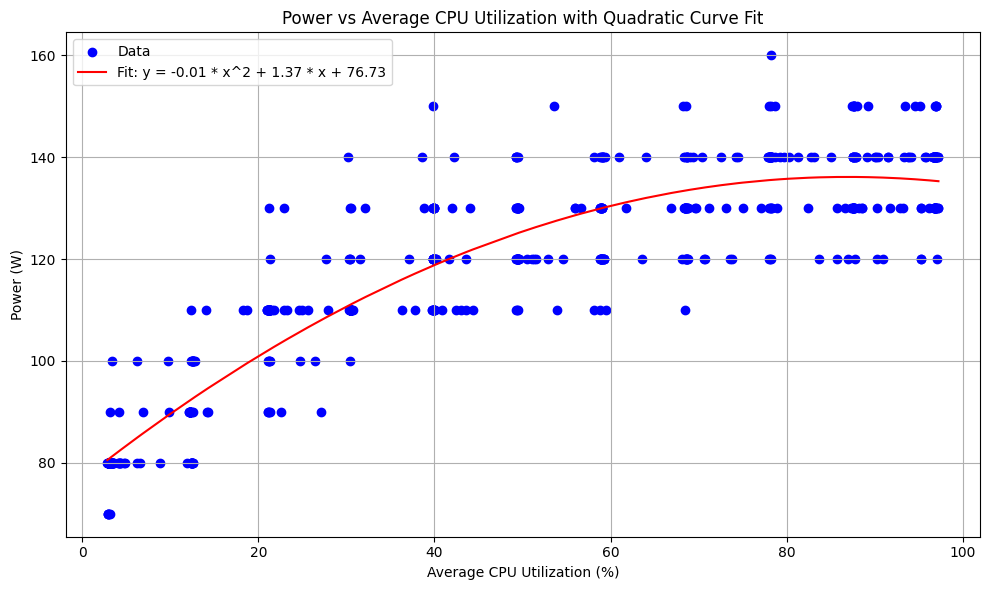

In [222]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

# Define the quadratic model function: y = a * x^2 + b * x + c
def quadratic_model(x, a, b, c):
    return a * x**2 + b * x + c

# Extract x and y data
x_data = df['avg_cpu_utilization']
y_data = df['Power']

# Perform curve fitting
popt, pcov = curve_fit(quadratic_model, x_data, y_data)

# Obtain the fitted parameters
a_fit, b_fit, c_fit = popt

# Predicted y values based on the fitted model
y_fit = quadratic_model(x_data, a_fit, b_fit, c_fit)

# Sorting x_data and corresponding y_data
sorted_indices = np.argsort(x_data)
x_sorted = x_data.iloc[sorted_indices]
y_sorted = y_data.iloc[sorted_indices]
y_fit_sorted = y_fit[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x_sorted, y_sorted, color='blue', label='Data')
plt.plot(x_sorted, y_fit_sorted, color='red', label=f'Fit: y = {a_fit:.2f} * x^2 + {b_fit:.2f} * x + {c_fit:.2f}')
plt.title('Power vs Average CPU Utilization with Quadratic Curve Fit')
plt.xlabel('Average CPU Utilization (%)')
plt.ylabel('Power (W)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Neural Network

In [223]:
# Extract individual CPU usage columns
cpu_regression_df = df['cpu_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
cpu_regression_df.columns = [f'cpu_usage_{col}' for col in cpu_regression_df.columns]

# Extract individual CPU usage columns
mem_regression_df = df['mem_usage_percentage'].apply(pd.Series)

# Rename columns to have a prefix
mem_regression_df.columns = [f'mem_usage_{col}' for col in mem_regression_df.columns]

regression_df = pd.concat([cpu_regression_df, mem_regression_df, df['Power']], axis=1)

# Replace NaN values with 0
regression_df.fillna(0, inplace=True)

regression_df.head()

,cpu_usage_cillium1,cpu_usage_cillium3,cpu_usage_cillium2,cpu_usage_cillium4,mem_usage_cillium1,mem_usage_cillium3,mem_usage_cillium2,mem_usage_cillium4,Power
0,5.76,0.70,0.0,0.0,7.97,2.99,0.0,0.0,80
1,5.91,0.76,0.0,0.0,7.97,2.99,0.0,0.0,80
2,5.42,0.78,0.0,0.0,7.89,2.98,0.0,0.0,80
3,5.22,0.77,0.0,0.0,7.88,2.99,0.0,0.0,80
4,5.41,0.71,0.0,0.0,7.89,2.98,0.0,0.0,80


In [227]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Prepare the data
X = regression_df.drop('Power', axis=1)  # Features
y = regression_df['Power']               # Target variable

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, shuffle=True)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer with a single node
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=3, verbose=1, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/100


c:\Users\Patchapong\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 12885.5518 - val_loss: 7316.1021
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2966.2366 - val_loss: 696.3106
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 546.4151 - val_loss: 481.6670
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 350.8574 - val_loss: 377.0136
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 311.3552 - val_loss: 312.3148
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 263.8464 - val_loss: 250.4179
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206.1367 - val_loss: 223.3306
Epoch 8/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183.2974 - val_loss: 163.7860
Epoch 9/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.3856 - val_loss: 142.6930
Epoch 10/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114.8137 - val_loss: 111.8250
Epoch 11/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126.2218 - val_loss: 110.0548
Epoch

In [228]:
# Make predictions
y_train_pred = model.predict(X_train).flatten()  # Flatten to make it 1D
y_test_pred = model.predict(X_test).flatten()    # Flatten to make it 1D

# Evaluate the model
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Training Mean Squared Error: {mse_train}")
print(f"Test Mean Squared Error: {mse_test}")
print(f"Training R^2 Score: {r2_train}")
print(f"Test R^2 Score: {r2_test}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Mean Squared Error: 55.67439522793302
Test Mean Squared Error: 85.60381533082591
Training R^2 Score: 0.8868585824966431
Test R^2 Score: 0.8397026062011719


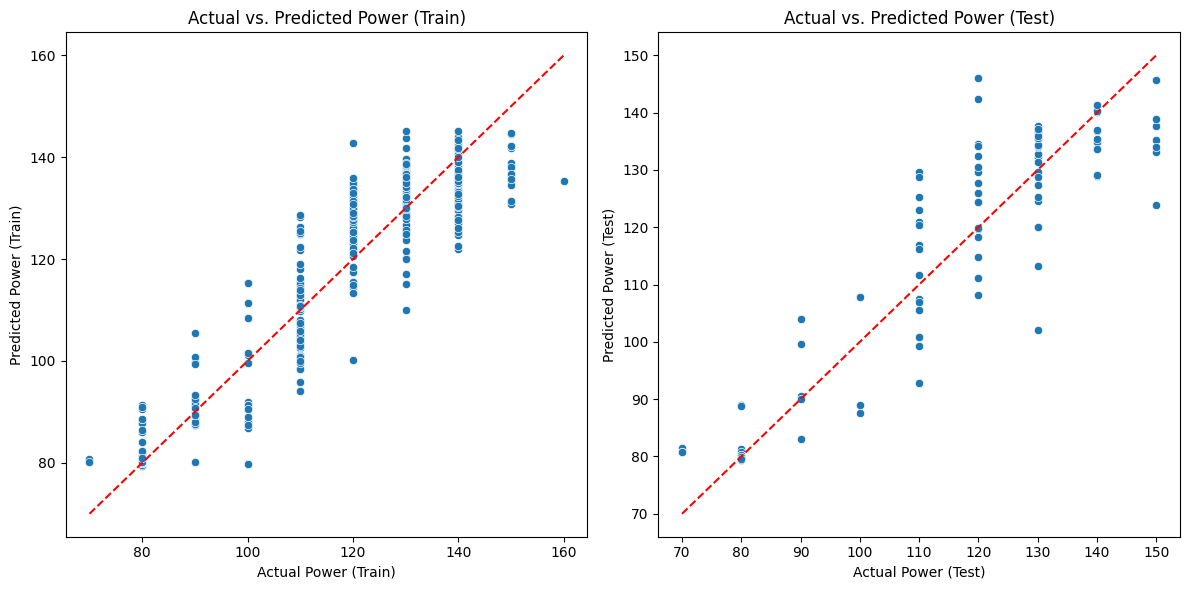

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
plt.figure(figsize=(12, 6))

# Scatter plot of training data
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_train, y=y_train_pred)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Train)')
plt.ylabel('Predicted Power (Train)')
plt.title('Actual vs. Predicted Power (Train)')

# Scatter plot of test data
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_test_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Actual Power (Test)')
plt.ylabel('Predicted Power (Test)')
plt.title('Actual vs. Predicted Power (Test)')

plt.tight_layout()
plt.show()